In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

from typing import Callable
from math import ceil
from pylab import rcParams
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, f1_score
from inspect import getfullargspec

%matplotlib inline
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 8

pd.options.display.max_columns = 100

In [2]:
df = pd.read_csv('train.csv', sep=';', on_bad_lines='skip')

df.sample(5)

,DateTime,Person_Id,Contract_Id,Account_Id,AccountPart_Id,Instrument_Id,Quantity,Number,ExternalAccount,Comments,ДатаДокумента,ВидДокумента,ВидОперации,НомерВходящегоДокумента,ДатаВходящегоДокумента,СуммаДокумента,ВалютаДокумента,СчетБанк,СчетОрганизации,СчетОрганизацииНомерСчета,СчетОрганизацииБанк,Контрагент,КонтрагентИНН,СчетКонтрагента,СчетКонтрагентаНомерСчета,СчетКонтрагентаБанк,СчетУчетаРасчетовСКонтрагентом,СубконтоДт1,СубконтоДт2,СубконтоДт3,СубконтоДт4,СубконтоДт5,СтатьяДвиженияДенежныхСредств,ЦеннаяБумага,НоменклатурнаяГруппа,НазначениеПлатежа,ДоговорКонтрагентаРасшифровкаПлатежа,СтатьяДвиженияДенежныхСредствРасшифровкаПлатежа,СуммаПлатежаРасшифровкаПлатежа,СтавкаНДСРасшифровкаПлатежа,СуммаНДСРасшифровкаПлатежа,СчетУчетаРасчетовСКонтрагентомРасшифровкаПлатежа,СчетУчетаРасчетовПоАвансамРасшифровкаПлатежа,СчетНаОплатуРасшифровкаПлатежа,НоменклатурнаяГруппаРасшифровкаПлатежа,ЦеннаяБумагаРасшифровкаПлатежа,СтрокаНайдена
12548,24.05.2024 0:00:00,3419,10625,94548,92557,5,500000,40,40807810901680164830,{VO52210} Оплата по Договору купли-продажи цен...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Нет
9994,28.03.2024 0:00:00,8201,79345,73652,93705,5,"3071,25",18,40702810066000012267,Оплата по счету 1677 от 25.03.2024 г. за компл...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Нет
13247,19.06.2024 0:00:00,48528,79351,128492,93727,5,"368,68",61,40701810987360000124,Оплата по счету №1600 от 14.06.2024г. за возме...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Нет
1484,30.01.2024 0:00:00,2554,8857,172,39401,5,"45994,52",525,30603810400200914001,"Выплата по облигациям ООО ""Вита Лайн"", Рег.ном...",30.01.2024 0:00:00,ПоступлениеНаРасчетныйСчет,Прочее поступление,525.0,30.01.2024 0:00:00,"45994,52",руб.,55.04,ВК_НКО НРД 810-3-10 депозитарный,40701810300010000812,044525505 НКО АО НРД,НРД НКО АО,7.702165e+09,NaN,NaN,NaN,76.09,НРД НКО АО,Купонный доход,Акции,Купонный доход,NaN,Прочие поступления,NaN,Акции,"Выплата по облигациям ООО ""Вита Лайн"", Рег.ном...",NaN,Прочие поступления,"45994,52",20%,"7665,75",NaN,NaN,NaN,Акции,NaN,Да
8832,02.05.2024 0:00:00,3419,8552,36647,38313,5,"82577,81",853553,NaN,Расчет при увольнении по реестру №31 от 02.05....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Нет


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15240 entries, 0 to 15239
Data columns (total 47 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   DateTime                                          15240 non-null  object 
 1   Person_Id                                         15240 non-null  int64  
 2   Contract_Id                                       15240 non-null  int64  
 3   Account_Id                                        15240 non-null  int64  
 4   AccountPart_Id                                    15240 non-null  int64  
 5   Instrument_Id                                     15240 non-null  int64  
 6   Quantity                                          15240 non-null  object 
 7   Number                                            15240 non-null  object 
 8   ExternalAccount                                   15107 non-null  object 
 9   Comments         

### Поля которые нужно заполнить.
* ВидДокумента
* ВидОперации
* Контрагент
* СчетУчетаРасчетовСКонтрагентом
* Субконто1…5
* СтатьяДвиженияДенежныхСредств
* ЦеннаяБумага
* НоменклатурнаяГруппа

In [4]:
def data_vectorizer(data, column, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        # векторизация текстовых данных с помощью TF-IDF     
        X = vectorizer.fit_transform(data[column])   
    else:
        X = vectorizer.transform(data[column])   
    
    return pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out()), vectorizer    

In [5]:
def train_model(data, features, target):           
    X = data[features]
    y = data[target]
    
    model = LogisticRegression() 
    model.fit(X, y)    
    
    return model

In [6]:
data = df[~df["ВидОперации"].isna()]

In [7]:
data.shape

(8273, 47)

In [8]:
# выполним label-encoding
encoder = LabelEncoder().fit(data['ВидДокумента'])
data['ВидДокументаEnc'] = encoder.transform(data['ВидДокумента'])
encoder = LabelEncoder().fit(data['ВидОперации'])
data['ВидОперацииEnc'] = encoder.transform(data['ВидОперации'])

data_vectorize, vectorizer = data_vectorizer(data=data, column='Comments')
data = pd.concat([data, data_vectorize], axis=1)

#data = data.fillna(data['ExternalAccount'].mode()[0]) 
#data['ExternalAccountEnc'] = LabelEncoder().fit_transform(data['ExternalAccount'])

# делим набор для начала активного обучения
train_data, valid_data = train_test_split(data, train_size=0.2, random_state=42)
columns = list(data_vectorize.columns)
columns.append('Person_Id')
columns.append('Contract_Id')
columns.append('Account_Id')
columns.append('AccountPart_Id')
columns.append('ВидДокументаEnc')
# обучение модели
model = train_model(train_data, columns, 'ВидОперацииEnc')
# формируем итоговый набор с предсказанными классами
X = valid_data[columns]
y_predicted = model.predict(X) 
#auc = roc_auc_score(valid_data['ВидОперацииEnc'], y_predicted, average='micro')
f1 = f1_score(valid_data['ВидОперацииEnc'], y_predicted, average='micro')
print(f1)
# результат
df = pd.concat([pd.DataFrame(encoder.inverse_transform(y_predicted), columns=['ВидОперации']), valid_data], axis=1)
df.sample(10)

0.4002115123130382


,ВидОперации,DateTime,Person_Id,Contract_Id,Account_Id,AccountPart_Id,Instrument_Id,Quantity,Number,ExternalAccount,Comments,ДатаДокумента,ВидДокумента,ВидОперации,НомерВходящегоДокумента,ДатаВходящегоДокумента,СуммаДокумента,ВалютаДокумента,СчетБанк,СчетОрганизации,СчетОрганизацииНомерСчета,СчетОрганизацииБанк,Контрагент,КонтрагентИНН,СчетКонтрагента,СчетКонтрагентаНомерСчета,СчетКонтрагентаБанк,СчетУчетаРасчетовСКонтрагентом,СубконтоДт1,СубконтоДт2,СубконтоДт3,СубконтоДт4,СубконтоДт5,СтатьяДвиженияДенежныхСредств,ЦеннаяБумага,НоменклатурнаяГруппа,НазначениеПлатежа,ДоговорКонтрагентаРасшифровкаПлатежа,СтатьяДвиженияДенежныхСредствРасшифровкаПлатежа,СуммаПлатежаРасшифровкаПлатежа,СтавкаНДСРасшифровкаПлатежа,СуммаНДСРасшифровкаПлатежа,СчетУчетаРасчетовСКонтрагентомРасшифровкаПлатежа,СчетУчетаРасчетовПоАвансамРасшифровкаПлатежа,СчетНаОплатуРасшифровкаПлатежа,НоменклатурнаяГруппаРасшифровкаПлатежа,ЦеннаяБумагаРасшифровкаПлатежа,СтрокаНайдена,ВидДокументаEnc,ВидОперацииEnc,...,цод,части,частичная,частично,частичное,частичном,часть,через,черкизово,черногорэнерго,числе,чтпз,шашина,шд,шкафа,штрафа,ый,эйч,экзамена,экземпляров,эко,экспертиза,эл,электрической,электромагистраль,электронном,электронным,электронных,электрорешения,эм,энергетическая,энергоника,энергосбыт,энерготехсервис,эр,эс,эсэфай,эталон,эф,ювелит,югры,юл,юридические,якутия,якутская,январе,январь,январь2024,января,ятэк
6114,Перевод на другой счет организации,11.01.2024 0:00:00,2554.0,8857.0,172.0,39401.0,5.0,"32015,79",259,47407810900000021026,PMT.Id KD-DIV-220901-0227 Tot2. ISIN US458140...,11.01.2024 0:00:00,ПоступлениеНаРасчетныйСчет,Прочее поступление,259.0,11.01.2024 0:00:00,"32015,79",руб.,55.04,ВК_НКО НРД 810-3-10 депозитарный,40701810300010000812,044525505 НКО АО НРД,СПБ Банк ПАО (бывш. Бест Эффортс Банк ПАО),7.831000e+09,NaN,NaN,NaN,76.09,СПБ Банк ПАО (бывш. Бест Эффортс Банк ПАО),Дивиденды,Акции,Дивиденды по акциям,NaN,Прочие поступления,NaN,Акции,PMT.Id KD-DIV-220901-0227 Tot2. ISIN US458140...,NaN,Прочие поступления,"32015,79",20%,"5335,97",NaN,NaN,NaN,Акции,NaN,Да,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2558,Перевод на другой счет организации,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6052,Прочее поступление,28.03.2024 0:00:00,2554.0,8857.0,73248.0,62127.0,5.0,4050000,618,30414810000000000911,Возврат денежных средств со сч. инд. кл. обес...,28.03.2024 0:00:00,ПоступлениеНаРасчетныйСчет,Прочее поступление,618.0,28.03.2024 0:00:00,4050000,руб.,55.04,ВК-НКО НРД 810-0-22 спец.брокерский,40701810000022000812,044525505 НКО АО НРД,НКЦ НКО АО,7.750004e+09,NaN,NaN,NaN,76.09,НКЦ НКО АО,15779 от 04.03.2019,Акции,Денежные средства по акциям,NaN,Прочие поступления,NaN,Акции,Возврат денежных средств со сч. инд. кл. обес...,NaN,Прочие поступления,4050000,NaN,0,NaN,NaN,NaN,Акции,NaN,Да,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5741,Перевод на другой счет организации,13.06.2024 0:00:00,2554.0,8502.0,183.0,38391.0,5.0,"11040,01",950,40702810701300002057,Оплата по счету 240531153 от 31 мая 2024 г. Оп...,13.06.2024 0:00:00,СписаниеСРасчетногоСчета,Оплата поставщику,950.0,13.06.2024 0:00:00,"11040,01",руб.,51.00,ВК_Промсвязьбанк 810-5-901,40701810550140856901,"044525555 ПАО ""ПРОМСВЯЗЬБАНК""",ОСК ООО,7.705658e+09,"р/с 40702810701300002057 в 044525593 АО ""АЛЬФА...",4070281070

In [9]:
with open("modle.pkl", "wb") as f:
    pickle.dump(model, f)

In [10]:
with open("modle.pkl", "rb") as f:
    model = pickle.load(f)

https://habr.com/ru/articles/548910/

In [11]:
class DataFrame(pd.DataFrame):
    """расширение DataFrame"""
    @property    
    def columns_num(self):
        """количественные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['uint8', 'int32', 'int64', 'float32', 'float64']).columns.tolist()
        
    @property    
    def column_cat(self):
        """номинативные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['object', 'category']).columns.tolist()                                  
    
    def columns_except(self, columns, excepts):
        return self[[item for item in columns if item not in excepts]]
    
class DataPipeline:     
    def __init__(self, **kwargs):
        """Инициализация класса"""                 
        # уровень стат значимости
        self.alpha = 0.05
        # срнднйи уровень корреляции
        self.corr = 0.7
        # объясненная дисперсия компонента
        self.varatio = 0.8
        # пороговое значение в три сигмы
        self.threashold = 3    
        # пропорции деления набора
        self.test_size = 0.33
        # кодировщики
        self.__encoders__ = dict()
        
        # параметры класса
        for key, value in kwargs.items():
            setattr(self, f"__{key}__", value)    
            
        assert self.__target__ is not None                  
        assert self.__features__ is not None                  
        assert self.__train_data__ is not None            
        
        # подготовка обучения            
        self.__train_data__  = self.prepare(self.__train_data__)        

    def __getstate__(self) -> dict:
        state = dict()    

        state["encoders"] = self.__encoders__
        state["model"] = self.__model__
        state["features"] = self.__features__
        state["target"] = self.__target__        
        
        return state
    
    def __setstate__(self, state: dict):            
        self.__encoders__ = state["encoders"]
        self.__model__ = state["model"]
        self.__features__ = state["features"]
        self.__target__ = state["target"]

    def prepare(self, data):
        data = DataFrame(data[self.__features__ + [self.__target__] if self.__target__ in data.columns else []])
        data = DataFrame(data[~data[self.__target__].isna()])                    

        return data
    
    def sc_data(func: Callable):
        """Декоратор стандартизации"""
        def wrapper(self, data):                     
            # стандартизация обучения                    
            self.__sc_train_data__ = func(self, data)                  
            # исключение целевой переменной из количественных признаков            
            column = self.__sc_train_data__.columns_except(self.__sc_train_data__.columns_num, self.__target__).columns
            # создаем стандартизатор
            if "scaler" not in self.__encoders__:
                self.__encoders__["scaler"] = StandardScaler()        
                self.__encoders__["scaler"].fit(self.__sc_train_data__[column])                           
            # стандартизация признаков                                     
            self.__sc_train_data__ = DataFrame(pd.concat([DataFrame(self.__encoders__["scaler"].transform(self.__sc_train_data__[column]), columns=column, index=self.__sc_train_data__.index),\
                                                     self.__sc_train_data__[self.__sc_train_data__.column_cat]], axis=1))                        
            #print("train resize")
            # понижение размерности                   
            #self.sc_train_data = DataFrame(self._resize_(self.sc_train_data))                                            
            
        return wrapper    
    
    @sc_data
    def transform(self, data):       
        """Трансформация данных"""          
        data[self.__target__] = data[self.__target__].astype("category")
        # заменяем inf на nan тогда моедль сможет их предсказать
        data.replace([np.inf, -np.inf], np.nan, inplace = True)
        
        # обработка количественных признаков    
        for item in data.columns_num:            
            data = self._transform_num_(data, item)                                                                                     
                
        # обработка текстовых признаков
        for item in data.column_cat:                   
            data = self._transform_vec_(data, item)
        
        # обработка номинальных признаков
        for item in data.column_cat:                   
            data = self._transform_cat_(data, item)                    
        
        return data

    def _transform_vec_(self, data, column):        
        """Векторизация текстовых признаков"""                         
        if column in self.__features__:        
            data[column] = data[column].fillna(data[column].mode()[0])                    
            
            if column not in self.__encoders__:                
                self.__encoders__[column] = TfidfVectorizer()        
                self.__encoders__[column].fit(data[column])                            
                
            # векторизация текстового признака
            vect = self.__encoders__[column].transform(data[column])                                        
            data = DataFrame(pd.concat([data.columns_except(data.columns, column),\
                                       DataFrame(vect.todense(), columns=self.__encoders__[column].get_feature_names_out(), index=data.index)], axis=1))            
            
        return data            

    def _transform_cat_(self, data, column):
        """Трансформация номинальных признаков"""                         
        # заменяем пропуски модой                                   
        data[column] = data[column].fillna(data[column].mode()[0])                    
        # создаем кодировщик
        if column not in self.__encoders__:
            self.__encoders__[column] = LabelEncoder()        
            self.__encoders__[column].fit(data[column])                    
        # кодируем признак                         
        data[column] = self.__encoders__[column].transform(data[column])                    
        # возвращаем тип признака из числового после кодирования
        data[column] = data[column].astype("category")
        
        return data        
        
    def _transform_num_(self, data, column):        
        """Трансформация количественных признаков"""        
        if len(data) == 1:
            return data
        # пробуем предсказать пропуски                        
        cdata = DataFrame(data.copy()) 
        # запомнинание пропусков        
        cdata['isna'] = np.where(cdata[column].isna(), True, False)                                             
        # заполнение пропусков в копии, т.к моедель не работает с ними
        for item in cdata.column_cat:            
            if cdata[item].isna().values.any():
                cdata[item] = cdata.fillna(cdata[item].mode())        
        for item in cdata.columns_num:
            if cdata[item].isna().values.any():
                cdata[item] = cdata.fillna(cdata[item].mean())                   
        # предсказание пропусков если можно сформировать обучающий и тестовый набор
        if True in cdata['isna'].values and False in cdata['isna'].values:
            # используем простую модель
            model = LinearRegression()
            # формируем тестовый и обучающий набор
            X_test = cdata.columns_except(cdata.columns, column)[cdata['isna']==True]
            X_train = cdata.columns_except(cdata.columns, column)[cdata['isna']==False]
            y_train = cdata[cdata['isna']==False][column]                    
            # обучение модели
            model.fit(X_train, y_train)
            # выполняем предсказание пропущенного прзнака        
            data.loc[cdata['isna'], [column]] = model.predict(X_test)                                      
        
        # очень странно, если не трогать целевую переменную или выполнить её винсоризацию,
        # то результат обучения модели существенно лучше, хотя мат статистика по ней хуже чем после zscore?
        # bins по целевой переменной решает проблему статистики, но предсказание модели теперь имеют погрешность бина
        if column == self.__target__:            
            data[column] = winsorize(data[column], limits=[0.1, 0.1])                                                            
        
        # обработка выбрасов, вычисляем z-Score в цикле пока не подавим их все       
        while column != self.__target__:            
            z = np.abs(stats.zscore(data[column]))                                                     
            if not z[z > self.threashold].any():
                break            
            # среднее если данные имеют нормальное распределение, иначе медиана                                    
            if stats.shapiro(data[column].values.reshape(-1))[1] > self.alpha:                        
                data.loc[z > self.threashold, column] = data[column].mean()            
            else:            
                data.loc[z > self.threashold, column] = data[column].median()                                                          
        
        return data          
    
    def _resize_(self, data, level = 0):
        """понижение размерности"""           
        m_corr, level = data.corr(), level + 1        
        for item in m_corr.columns:            
            # поиск взаимокорреляции признаков по матрице
            column = list(m_corr[m_corr[item] > self.corr].index)
            # корреляция не с самим собой и не одни компоненты 
            if len(column) > 1 and not all('component' in item for item in column):
                dim_reducer = PCA(n_components=1, random_state=42)                
                components = dim_reducer.fit_transform(data[column])                            
                # уровень дисперсии достаточен для свертывания
                if dim_reducer.explained_variance_ratio_ >= self.varatio:
                    data = DataFrame(pd.concat([data.drop(column, axis=1),\
                                                pd.DataFrame(data = components, columns = [f'component_{level}'])], axis=1))                                                                                                
                    # результат свертки
                    print(f'{column} -> component_{level} var:{dim_reducer.explained_variance_ratio_}')
                    # рекурсивный поиск компонент
                    return self._resize_(data, level)               
        return data     

    @property
    def train_data(self):
        return DataFrame(self.__train_data__)
        
    @property
    def sc_train_data(self):
        return DataFrame(self.__sc_train_data__)

    @property
    def encoders(self):
        return self.__encoders__          
    
    @property
    def model(self):
        return self.__model__        
    
    def split(self, X, y):
        """Разделение набора"""             
        return train_test_split(X, y, test_size=self.test_size, random_state=42)
    
    def search_param(self, data):
        """Поиск гиперпараметров"""        
        params = {
            'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson', 'gini', 'entropy'],
            'n_estimators': [item for item in range(10, 100, 10)],            
            'max_depth': [item for item in range(1, 10, 2)],
            'max_features': [item for item in range(1, 10, 2)],
            'min_samples_leaf': [item for item in range(1, 10, 2)],
        }

        clf = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_grid=params,            
            scoring='roc_auc',
            n_jobs=-1,
            cv=5
        )              
        # формируем X и y из обучающего набора
        X_train, X_valid, y_train, y_valid = self.split(self.__sc_train_data__, self.__train_data__ [self.__target__])
        # искать праметры лучше на всеъ данных
        clf.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
        
        return clf.best_params_
    
    def fit(self, model, data):
        """Обучение модели"""                     
        self.__model__ = model
        # разделение набора на обучающий и проверочный
        X_train, X_valid, y_train, y_valid = self.split(data.columns_except(data.columns, self.__target__), data[self.__target__])
        
        self.__model__.fit(X_train, y_train)                        
        
        return self.__model__
        
    def predict(self, model, data):
        """Предсказание зависимой переменной"""        
        return model.predict(data.columns_except(data.columns, self.__target__))    
    
    def importances(self, model, data):
        """оценка признаков модели"""                                
        return pd.DataFrame(zip(data.columns_except(data.columns, self.__target__).columns, model.feature_importances_),\
                            columns = ['name', 'value']).sort_values(by = 'value', ascending = False)                          
    
    def scatterplot(self, model, data):
        """график scatterplot качесива модели"""    
        X_train, X_valid, y_train, y_valid = self.split(data.columns_except(data.columns, self.__target__), data[self.__target__])

        y_pred = self.predict(model, DataFrame(X_train))    
        
        plt.subplot(121)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')                
        plt.title(f"train f1:{round(f1_score(y_train, y_pred, average='micro'), 3)}")        
        sns.scatterplot(x = y_train, y = y_pred)
        
        y_pred = self.predict(model, DataFrame(X_valid))        
        
        plt.subplot(122)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')                
        plt.title(f"valid f1:{round(f1_score(y_valid, y_pred, average='micro'), 3)}")        
        sns.scatterplot(x = y_valid, y = y_pred)

        plt.show()                      

    def boxplot(self, data):
        """график box-plot"""                           
        data.boxplot(column = data.columns_num, grid = False, rot = 45)
        
    def corrplot(self, data):
        """график корреляции"""              
        plt.title('Корреляционная матрица')
        sns.heatmap(data.corr(), annot = True)
        plt.show()

ВидДокумента


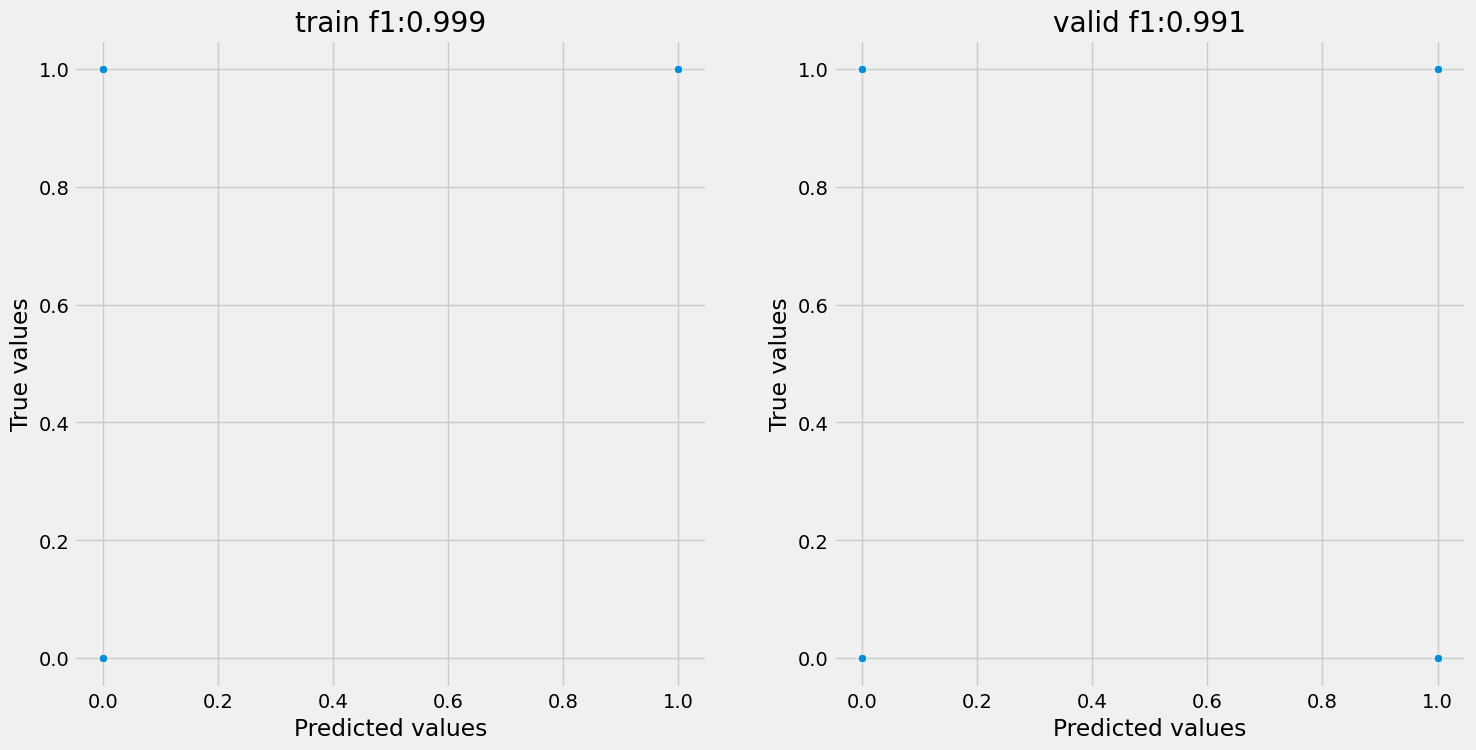

ВидОперации


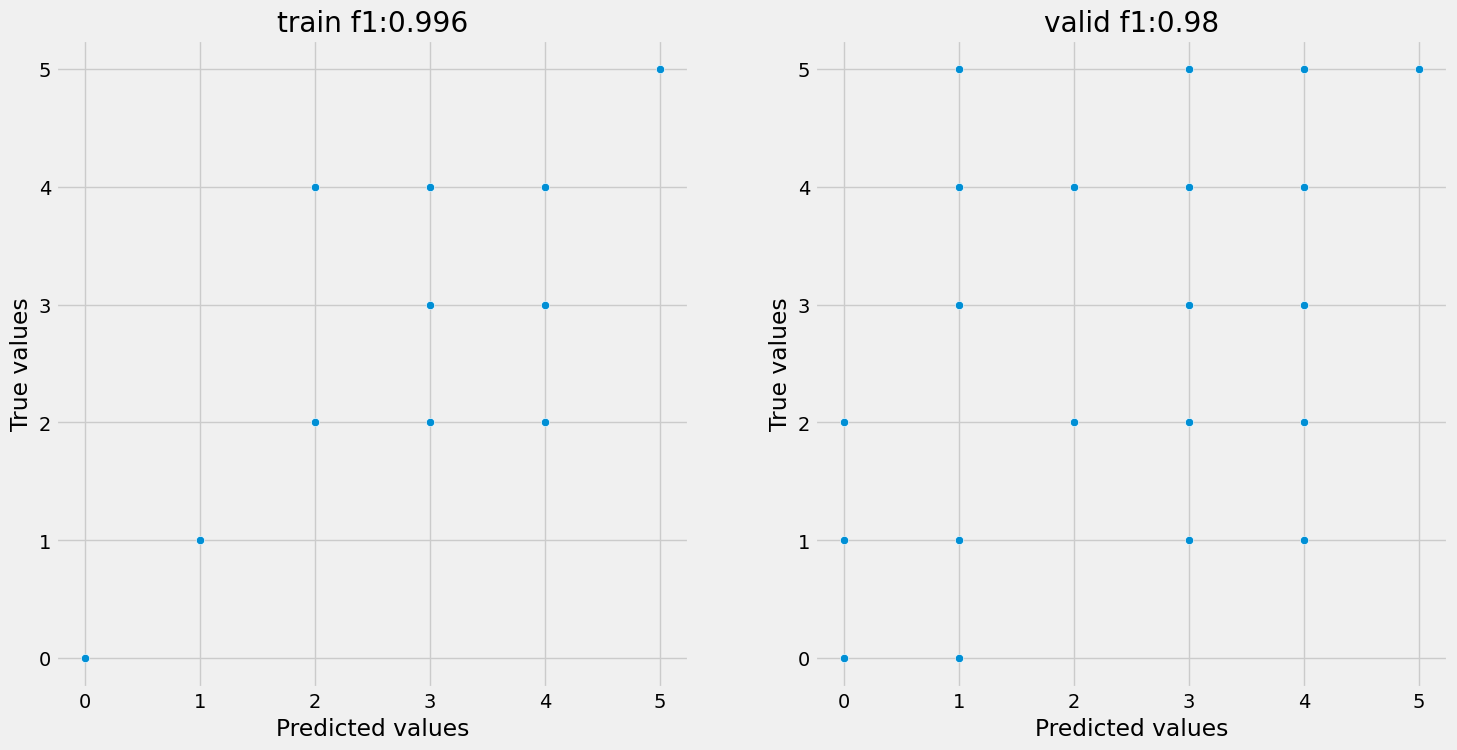

Контрагент


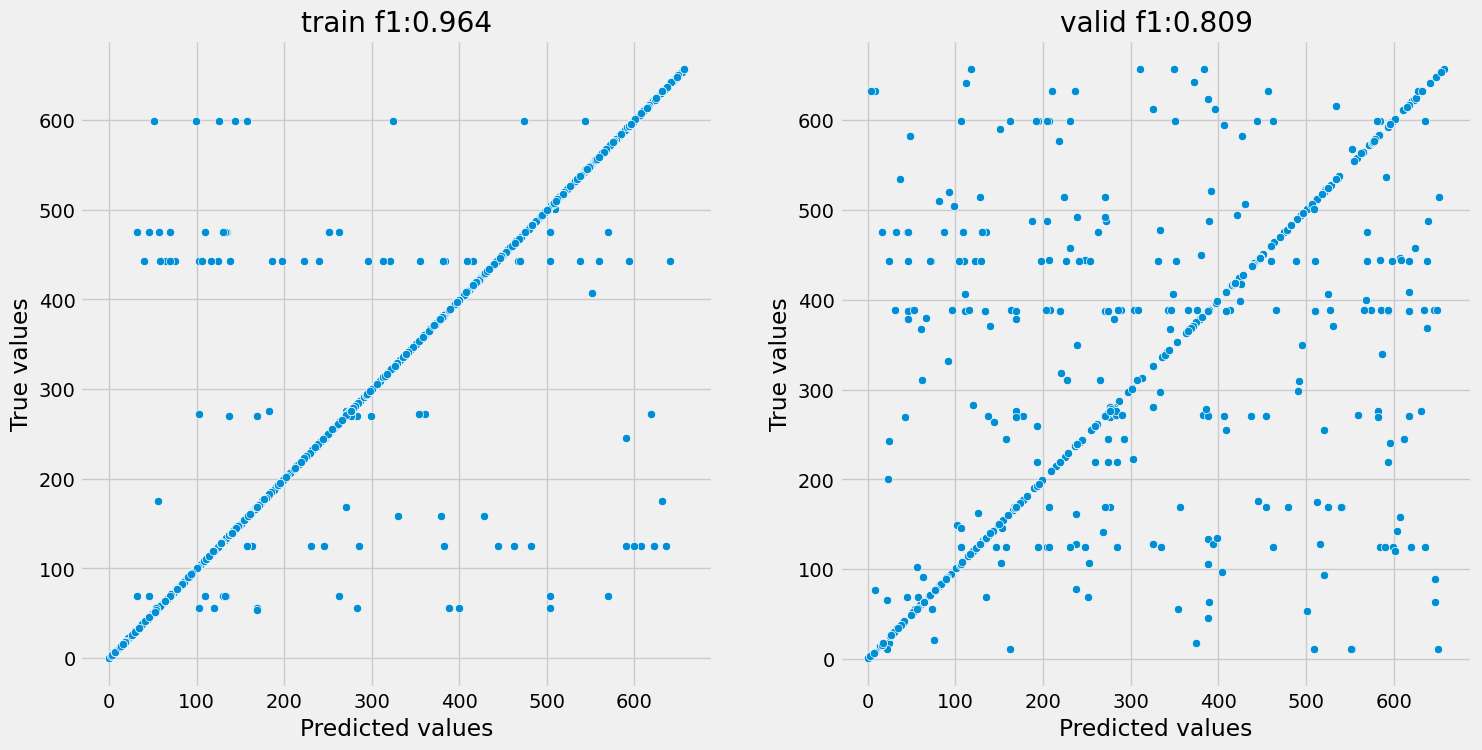

СчетУчетаРасчетовСКонтрагентом


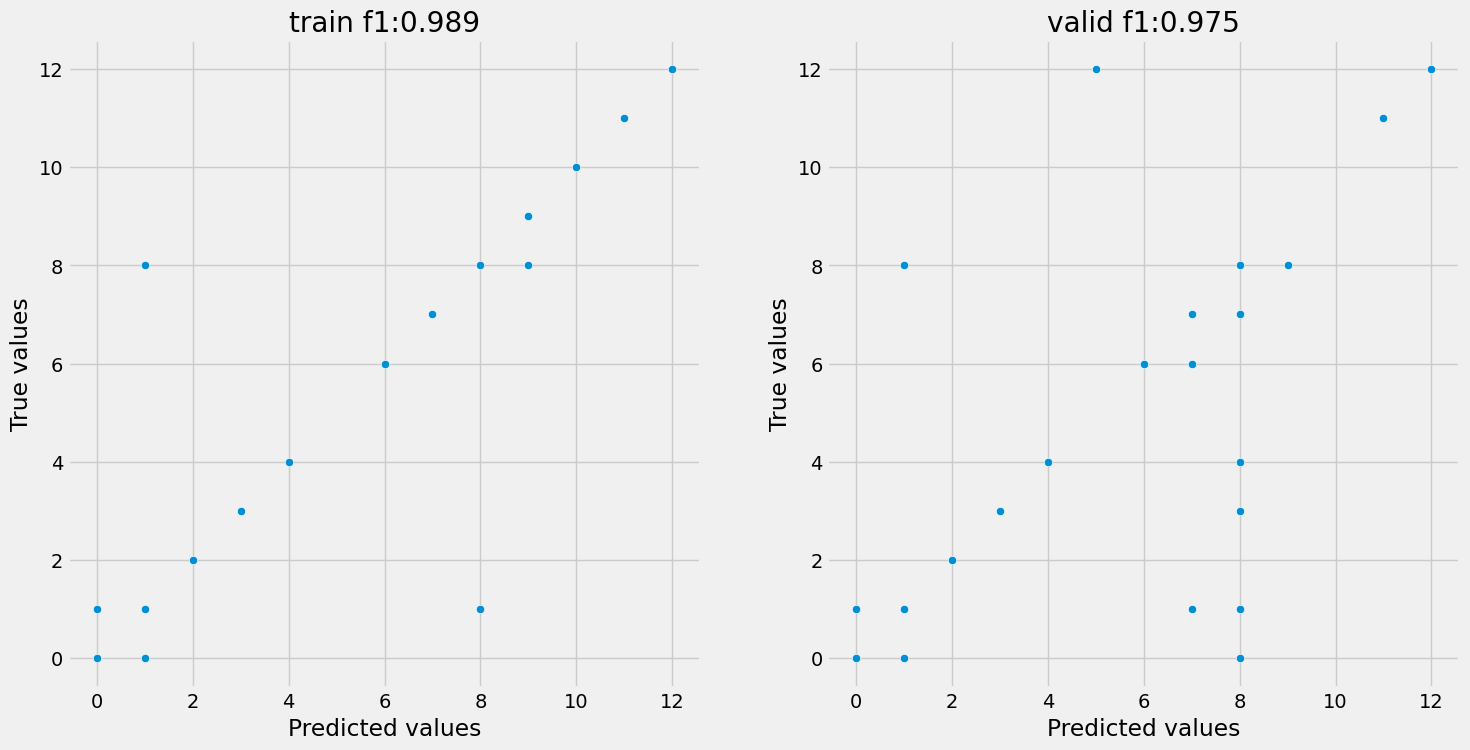

СтатьяДвиженияДенежныхСредств


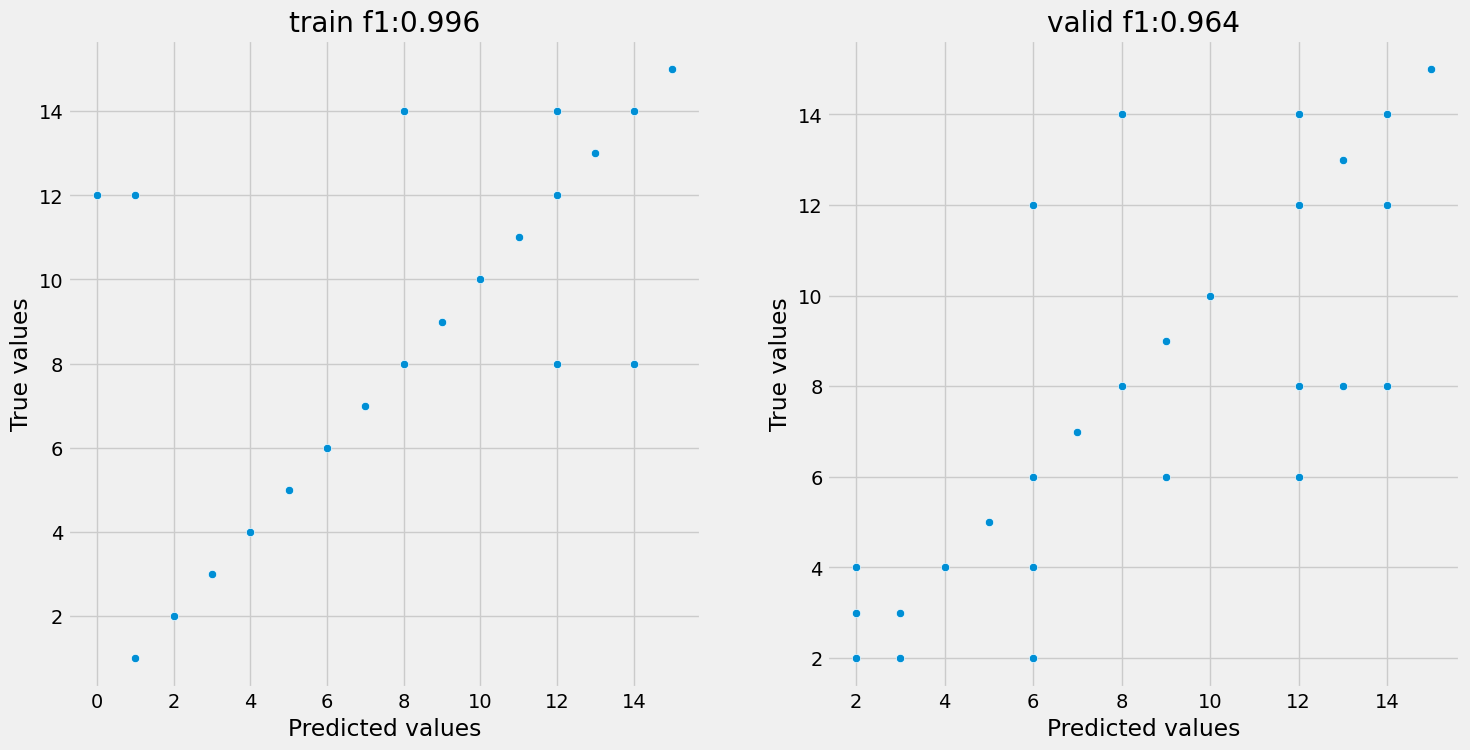

ЦеннаяБумага


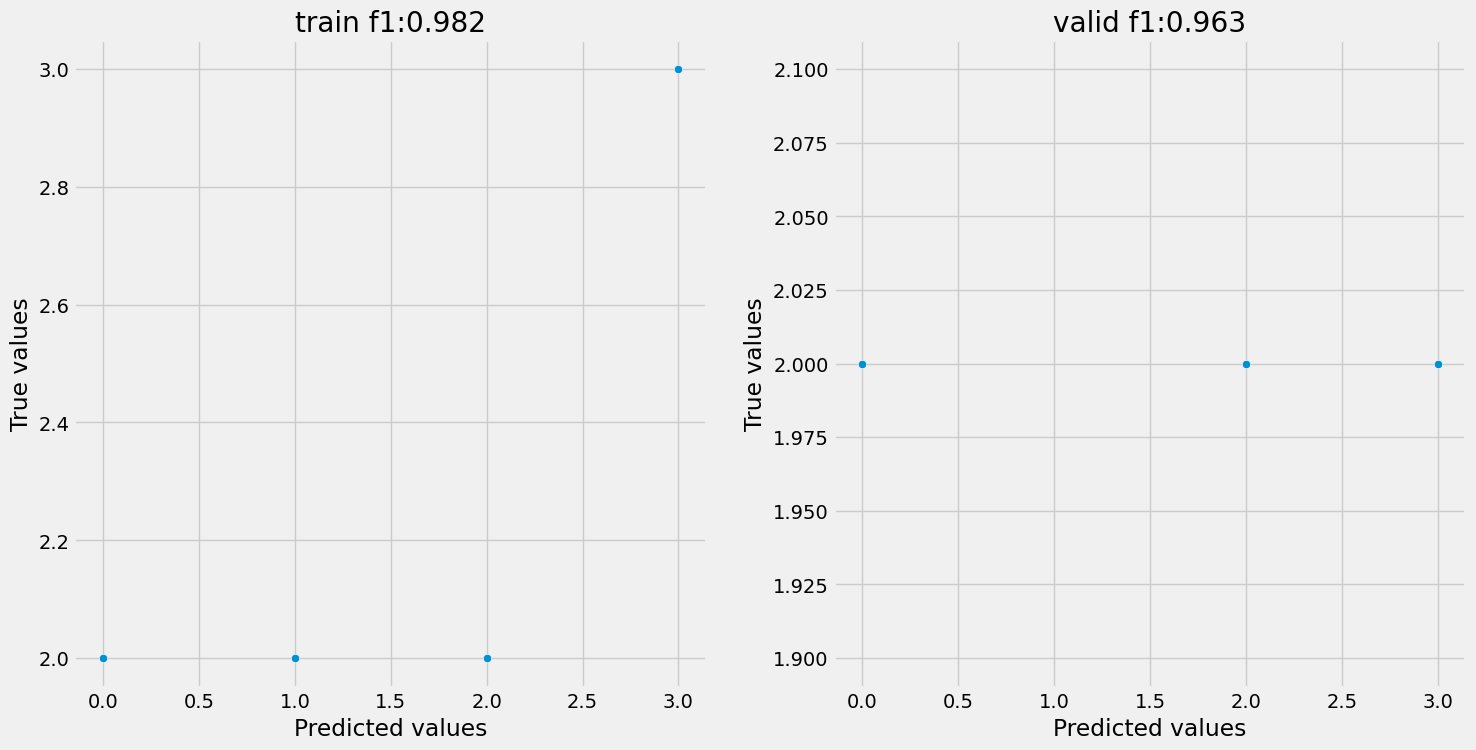

НоменклатурнаяГруппа


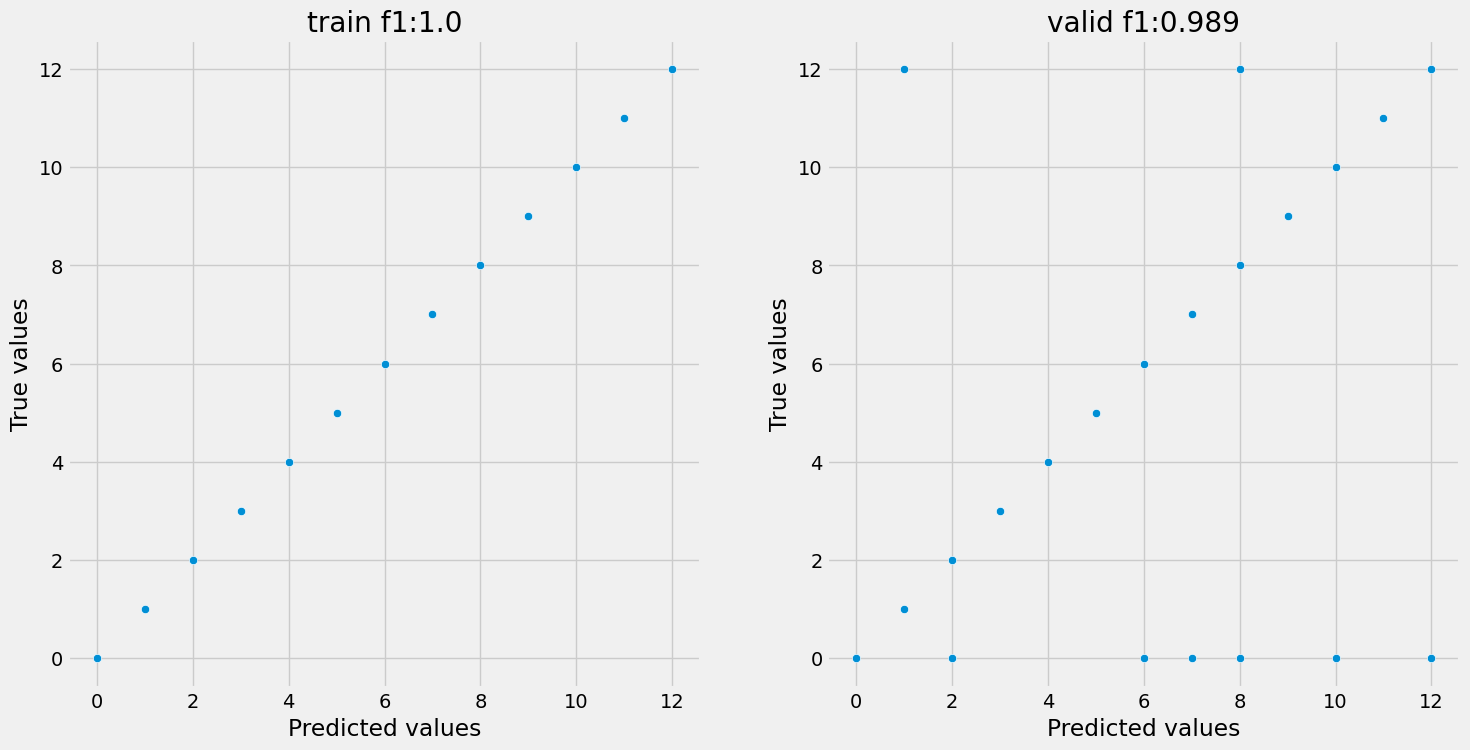

СубконтоДт1


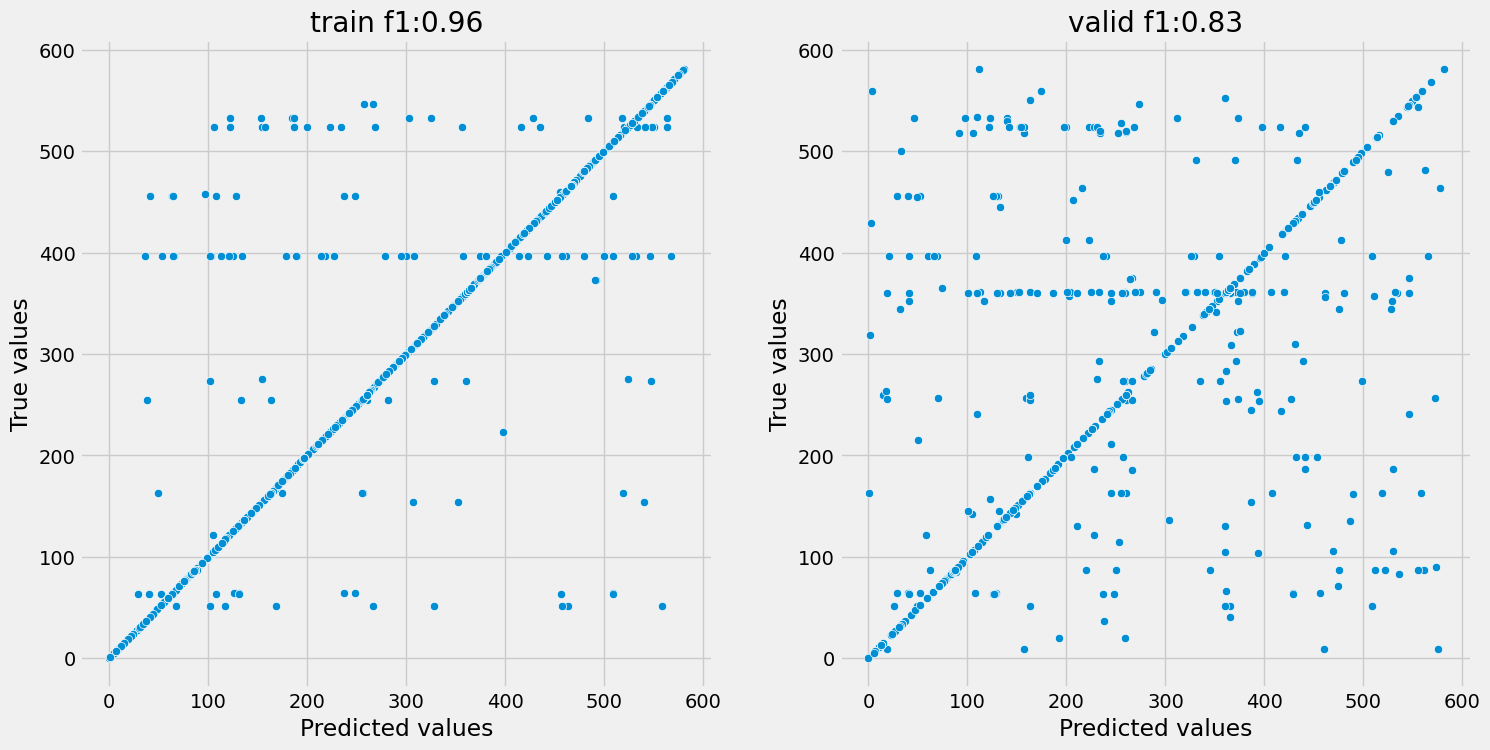

СубконтоДт2


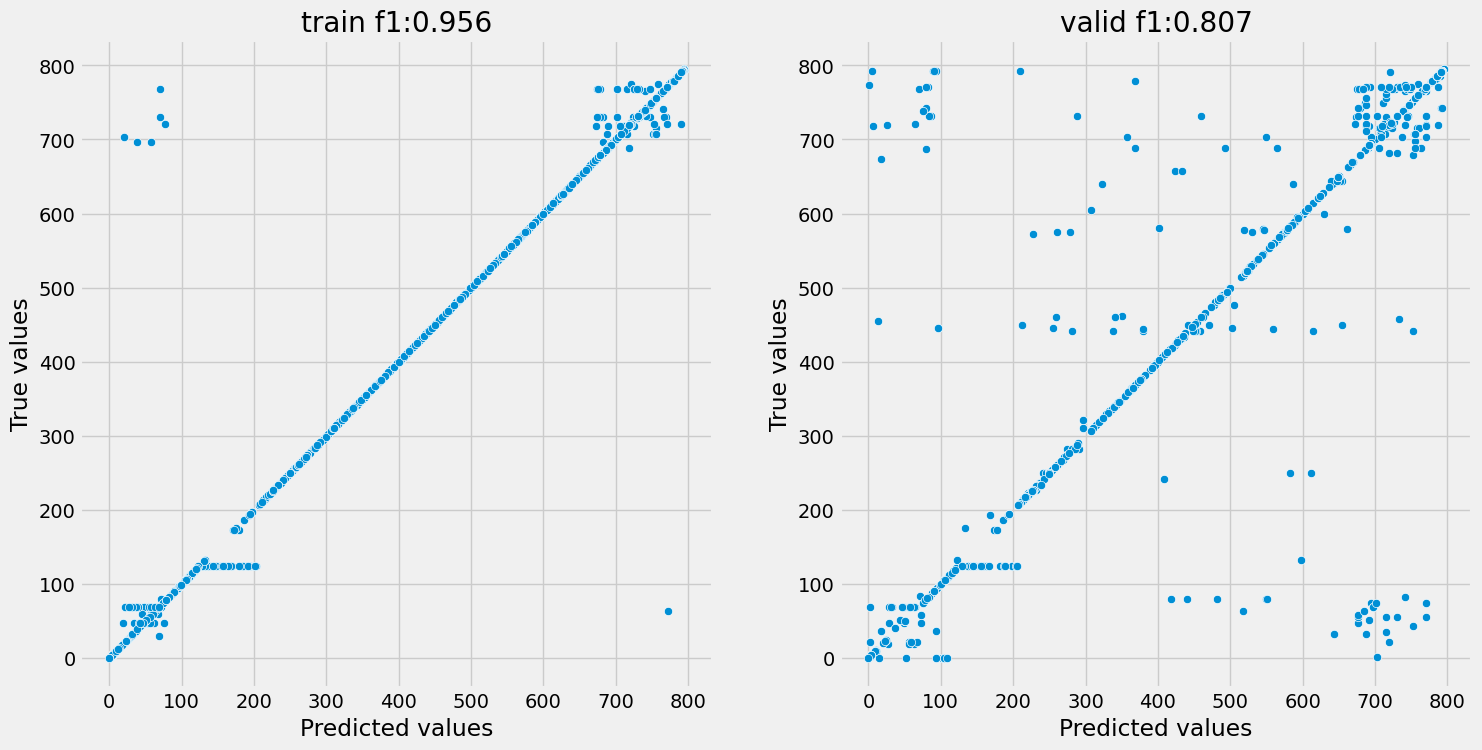

СубконтоДт3


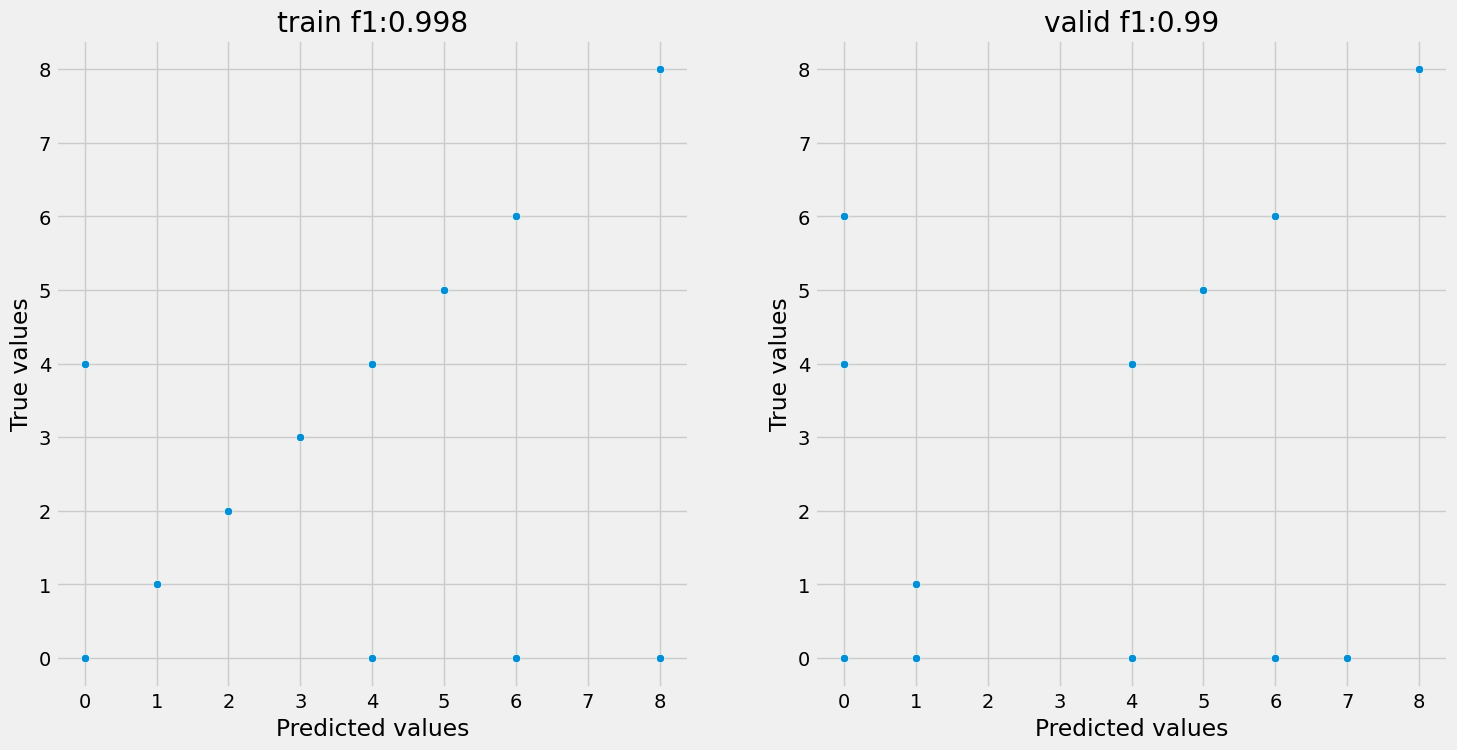

СубконтоДт4


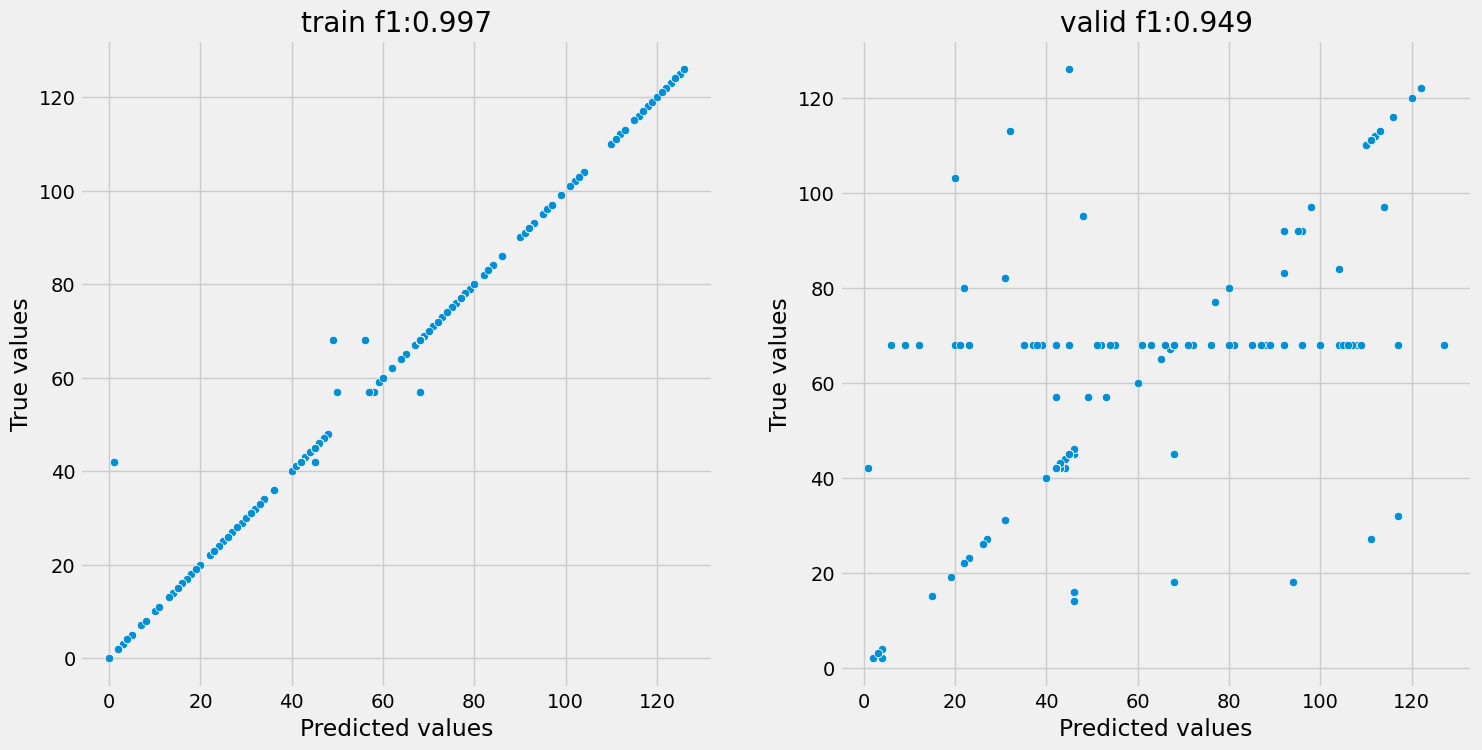

In [12]:
# загрузка обучающего набора
train_data = DataFrame(pd.read_csv("train.csv", sep=';', on_bad_lines='skip'))
pipelines = dict()
# обучения моделей для каждого целевой переменной
for target in ['ВидДокумента','ВидОперации','Контрагент','СчетУчетаРасчетовСКонтрагентом','СтатьяДвиженияДенежныхСредств','ЦеннаяБумага','НоменклатурнаяГруппа',\
               'СубконтоДт1','СубконтоДт2','СубконтоДт3','СубконтоДт4']:
    print(target)        
    pipeline = DataPipeline(train_data=train_data, features=['Person_Id','Contract_Id','Account_Id','AccountPart_Id','Comments'], target=target)    
    pipeline.transform(pipeline.train_data)    
    pipeline.fit(LogisticRegression(), pipeline.sc_train_data)
    pipeline.scatterplot(pipeline.model, pipeline.sc_train_data)
    # сериализация модели
    pipelines[target] = pickle.dumps(pipeline)     
# сохранение конвейеров в файл
with open("pipelines.pkl", "wb") as f:
    pickle.dump(pipelines, f)

In [13]:
#params = pipeline.search_param(pipeline.sc_train_data) 
#params = {'criterion': 'gini',  'max_depth': 9,  'max_features': 5,  'min_samples_leaf': 1,  'n_estimators': 90}
#model = pipeline.fit(RandomForestClassifier(**params), pipeline.sc_train_data)

In [14]:
# загрузка набора
data = DataFrame(pd.read_csv("train.csv", sep=';', on_bad_lines='skip'))
# загрузка конвейера
with open("pipelines.pkl", "rb") as f:
    pipelines = pickle.load(f)
# получение конвейера
pipeline = pickle.loads(pipelines['ВидОперации'])
# загрузка target кодировщика
encoder = pipeline.encoders['ВидОперации']
# предсказание
pipeline.transform(pipeline.prepare(data[:1]))
print(encoder.inverse_transform(pipeline.predict(pipeline.model, pipeline.sc_train_data)))

['Прочее списание']


In [15]:
import json
from io import StringIO
# загрузка набора
data = DataFrame(pd.read_csv("train.csv", sep=';', on_bad_lines='skip'))

data_json = data[:1].to_json(orient="records", lines=True)
data = DataFrame(pd.read_json(data_json, typ='series')).transpose()
data = pipeline.prepare(data)
display(data)
pipeline.transform(data)
#print(encoder.inverse_transform(pipeline.predict(pipeline.model, pipeline.sc_train_data)))

,Person_Id,Contract_Id,Account_Id,AccountPart_Id,Comments,ВидОперации
0,2554,8857,143,39383,Отзыв денежных средств на основании Договора о...,Прочее списание


In [16]:
#data_json = json.dumps({"Person_Id":2554, "Contract_Id":8857, "Account_Id":143, "AccountPart_Id":29383, "Comments":"Отзыв денежных средств на основании Договора о брокерском обслуживании № VC-BC-200114/ 01 от 14.01.2020. НДС не облагается.", "ВидОперации":"Прочее списание"})
data_json = json.dumps({"Person_Id":2554, "Contract_Id":8857, "Account_Id":143, "AccountPart_Id":29383, "Comments":"Отзыв денежных средств на основании Договора о брокерском обслуживании № VC-BC-200114/ 01 от 14.01.2020. НДС не облагается."})
data = DataFrame(DataFrame(pd.read_json(data_json, typ='series')).transpose())
data["ВидОперации"] = encoder.classes_[0]
data = pipeline.prepare(data)
display(data)
pipeline.transform(data)
print(encoder.inverse_transform(pipeline.predict(pipeline.model, pipeline.sc_train_data)))

,Person_Id,Contract_Id,Account_Id,AccountPart_Id,Comments,ВидОперации
0,2554,8857,143,29383,Отзыв денежных средств на основании Договора о...,Оплата от покупателя


['Прочее списание']


In [36]:
pipeline = DataPipeline(train_data=DataFrame.from_dict({"col": None}, orient="index").transpose(), features=["col"], target="col")